In [2]:
from main import RF
from mmdit import MMDiT
import torch

rf = RF(
    MMDiT(
        in_channels=4,
        out_channels=4,
        dim=2560,
        global_conddim=2560,
        n_layers=24,
        n_heads=8,
        cond_seq_dim=1024,
    ),
    True,
).cuda()
rf.load_state_dict(torch.load("/home/host/simo/ckpts/5b/model_40961/ema2.pt", map_location="cpu"), strict = False)


/home/host/py39cuda/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2024-05-16 08:30:17,132] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to cuda (auto detect)
 [WARNING]  Please specify the CUTLASS repo directory as environment variable $CUTLASS_PATH
 [WARNING]  sparse_attn requires a torch version >= 1.5 and < 2.0 but detected 2.3
 [WARNING]  using untested triton version (2.3.0), only 1.0.0 is known to be compatible


<All keys matched successfully>

In [3]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
device = 'cuda:0'
t5tokenizer = AutoTokenizer.from_pretrained("EleutherAI/pile-t5-large", use_fast=False)
t5tokenizer.pad_token = t5tokenizer.bos_token
t5model = AutoModelForSeq2SeqLM.from_pretrained("EleutherAI/pile-t5-large")
t5model = t5model.to(device).eval()

In [55]:

@torch.no_grad()
def make_cond(cond_prompts, uncond_prompts = None,):
    if not isinstance(uncond_prompts, list):
        uncond_prompts = ["bad quality, jpeg"] * len(cond_prompts)
        
    allprompts = cond_prompts + uncond_prompts

    t5_inputs = t5tokenizer(
        allprompts,
        truncation=True,
        max_length=128,
        padding="max_length",    
        return_tensors="pt",
    )
    t5_inputs = {k: v.to(device) for k, v in t5_inputs.items()}
    t5_outputs = t5model.encoder(**t5_inputs)[0] # B, T, D
    # mask that by 0 for padding tokens
    mask = t5_inputs["attention_mask"].unsqueeze(-1).expand(t5_outputs.shape)
    t5_outputs = t5_outputs * mask

    return {'c_seq': t5_outputs[:len(cond_prompts)]}, {'c_seq': t5_outputs[len(cond_prompts):]}

captions = ["photo of very cute blue cat", "photo of a black dog", "illustration of yellow chair", "fireworks in the night"]
captions = ['dark wizard', 'picaso style woman art', 'rabbit with blue ears', 'tiger in the jungle']

conds, unconds = make_cond(captions)


In [56]:
STEPSIZE = 50
L = len(conds['c_seq'])

init_noise = torch.randn(L, 4, 32, 32).cuda()
images = rf.sample_with_xps(init_noise, conds, null_cond = unconds, sample_steps = STEPSIZE, cfg = 6.0)

In [40]:
from diffusers.image_processor import VaeImageProcessor
from diffusers.models import AutoencoderKL

vae = AutoencoderKL.from_pretrained("stabilityai/sdxl-vae").to("cuda:0")

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


In [57]:
images_for_grid = [[] for _ in range(L)]

for i, _ in enumerate(conds['c_seq'][:L]):
    for t in range(STEPSIZE):
        x = vae.decode(images[t][i : i + 1].cuda()/0.13025).sample
        img = VaeImageProcessor().postprocess(
            image=x.detach(), do_denormalize=[True, True]
        )[0]
        images_for_grid[i].append(img)

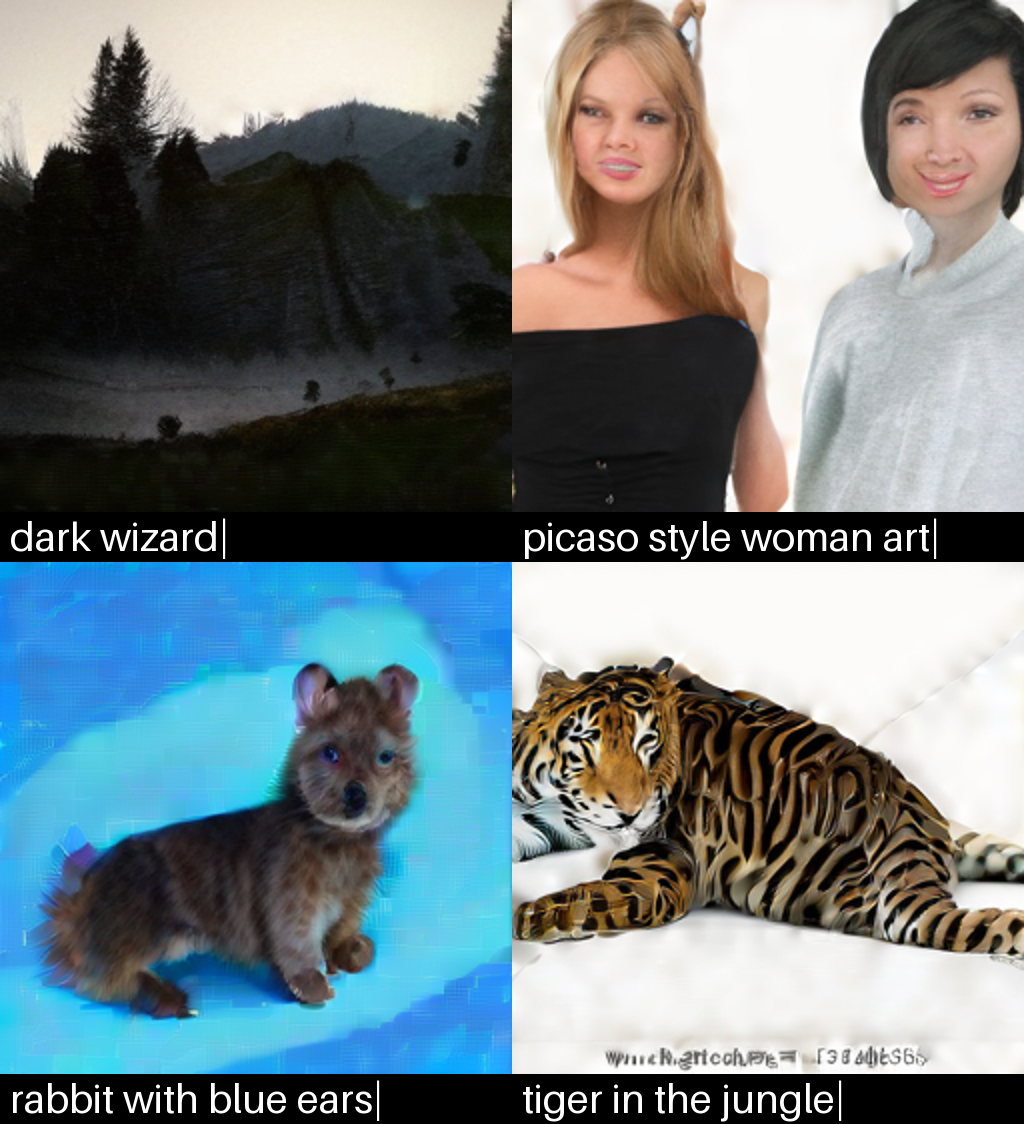

In [58]:
import PIL.Image as Image
import PIL.ImageDraw as ImageDraw
import PIL.ImageFont as ImageFont
import math

def add_caption(image, caption, font=None):
    draw = ImageDraw.Draw(image)
    width, height = image.size
    text_width, text_height = 40, 40
    text_x = 10
    text_y = height - text_height - 10  # Slightly above the bottom of the image
    draw.text((text_x, text_y), caption, fill="white", font=font)

grid_images = []
sL = math.ceil(math.sqrt(L))
show_captions = [f"{c}|" for i, c in enumerate(captions)]

# Load a font
try:
    font = ImageFont.truetype("arial.ttf", 40)
except IOError:
    font = ImageFont.load_default(40)

IW = 512
IH = 512 + 50

for t in range(STEPSIZE):
    grid = Image.new('RGB', (IW * sL, IH * sL))
    for i in range(L):
        img = images_for_grid[i][t].copy()
        # append bit of whitespace on the img
        ni = Image.new('RGB', (IW, IH))
        img = img.resize((IW, IW))
        ni.paste(img, (0, 0))
        img = ni

        add_caption(img, show_captions[i], font=font)
        grid.paste(img, (IW * (i % sL), IH * (i // sL)))
    grid_images.append(grid)

# Make it a gif and make the last image longer
grid_images += [grid_images[-1]] * 15

# Display the last image
grid_images[-1]

In [61]:
grid_images[-1].save('output_2.gif', save_all=True, append_images=grid_images[:-1], duration=100, loop=0)
